# Calculating Water Change at the Ethnologue Polygon Level

In [1]:
import os
import ee
import geemap 
import pandas as pd

#ee.Authenticate()
ee.Initialize()

c:\Users\juami\anaconda3\envs\geo\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



Successfully saved authorization token.


In [2]:
# Define region to view (Peru/Brazil Amazon)
world_bbox = ee.Geometry.BBox(-180, -85, 180, 85)

# Load the water change band
permwater = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("transition").eq(1)
losswater = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("transition").eq(3)

changewaterabs = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("change_abs")
changewater = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("change_norm")

In [20]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=permwater,
    description='perm_water_100m_30m',
    folder='GEE_exports',
    fileNamePrefix='perm_water_100m_30m',
    region=world_bbox,
    scale=100,
    maxPixels=1e13
)

task.start()

In [21]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=losswater,
    description='loss_water_100m_30m',
    folder='GEE_exports',
    fileNamePrefix='loss_water_100m_30m',
    region=world_bbox,
    scale=100,
    maxPixels=1e13
)

task.start()

In [22]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=changewater,
    description='change_water_100m_30m',
    folder='GEE_exports',
    fileNamePrefix='change_water_100m_30m',
    region=world_bbox,
    scale=100,
    maxPixels=1e13
)

task.start()

In [3]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=changewaterabs,
    description='change_water_100m_30m',
    folder='GEE_exports',
    fileNamePrefix='change_water_100m_30m',
    region=world_bbox,
    scale=100,
    maxPixels=1e13
)

task.start()

### NOTE: see the progress of exports at [GEE Task Manager](https://code.earthengine.google.com/tasks)

In [23]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

import mapclassify

from rapidfuzz import process, fuzz

from shapely.geometry import Point

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
from glob import glob
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [24]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
poscol_path = base_path / "data" / "raw" / "ethnologue" / "ancestral_characteristics_database_language_level" / "Ethnologue_16_shapefile" / "langa_no_overlap_biggest_clean.shp"

data_path = base_path / "data" / "interim"
maps_path = base_path / "maps" / "raw"
water_path = maps_path / "Water_surface" 

In [25]:
# Read the shapefiles and CSV files
ethnologue = gpd.read_file(poscol_path)

# Keep only relevant columns
ethnologue = ethnologue[["ID", "geometry"]]

print(f"Number of features: {len(ethnologue)}") 

Number of features: 7087


In [26]:
# List all the raster files 
raster_files = glob(str(water_path / "perm_water" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\perm_water\\perm_water_100m_30m-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\perm_water\\perm_water_100m_30m-0000000000-0000065536.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\perm_water\\perm_water_100m_30m-0000000000-0000131072.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\perm_water\\perm_water_100m_30m-0000000000-0000196608.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\perm_water\\perm_water_100m_30m-0000000000-0000262144.tif', 'C:\\Users\\juami\\Dropbox\\RAship

In [27]:
# Check CRS of each input raster
for i, src in enumerate(src_files_to_mosaic):
    print(f"Raster {i} CRS:", src.crs)

ethnologue = ethnologue.to_crs(src_files_to_mosaic[0].crs)

Raster 0 CRS: EPSG:4326
Raster 1 CRS: EPSG:4326
Raster 2 CRS: EPSG:4326
Raster 3 CRS: EPSG:4326
Raster 4 CRS: EPSG:4326
Raster 5 CRS: EPSG:4326
Raster 6 CRS: EPSG:4326
Raster 7 CRS: EPSG:4326
Raster 8 CRS: EPSG:4326
Raster 9 CRS: EPSG:4326
Raster 10 CRS: EPSG:4326
Raster 11 CRS: EPSG:4326
Raster 12 CRS: EPSG:4326
Raster 13 CRS: EPSG:4326
Raster 14 CRS: EPSG:4326
Raster 15 CRS: EPSG:4326
Raster 16 CRS: EPSG:4326
Raster 17 CRS: EPSG:4326
Raster 18 CRS: EPSG:4326
Raster 19 CRS: EPSG:4326
Raster 20 CRS: EPSG:4326


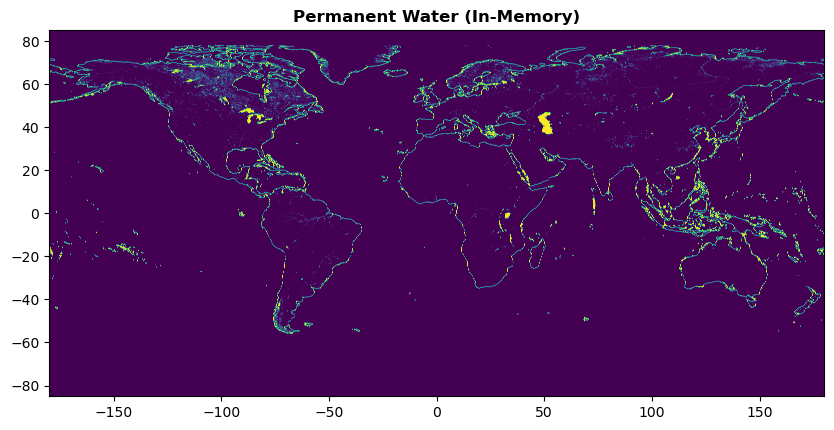

In [28]:
# Show the first band of the mosaic directly
fig, ax = plt.subplots(figsize=(10, 10))
show(mosaic, transform=out_trans, ax=ax, title="Permanent Water (In-Memory)")
plt.show()

In [29]:
# Threshold: create binary mask from mosaic
binary_mask = (mosaic[0] > 0).astype(np.uint8)  # 1 = perm water, 0 = non-water

# Save binary mask to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=binary_mask.shape[0],
        width=binary_mask.shape[1],
        count=1,
        dtype='uint8',
        transform=out_trans,
        crs='EPSG:4326' 
    ) as dataset:
        dataset.write(binary_mask, 1)

    # Compute zonal statistics using sum (since forest = 1, sum = count of pixels)
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['sum'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['permwater_pixels'] = [f['properties']['sum'] for f in stats]

# Calculate area in km² (each pixel = 0.01 km² at 100m resolution)
ethnologue['permwater_km2'] = ethnologue['permwater_pixels'] * 0.01

# View results
ethnologue[['ID', 'permwater_pixels', 'permwater_km2']].head()

,ID,permwater_pixels,permwater_km2
0,RUS-RUS,189623.0,1896.23
1,ENG-USA,81705.0,817.05
2,POR-BRA,55294.0,552.94
3,ENG-AUS,13438.0,134.38
4,CMN-CHN,17872.0,178.72


In [30]:
# List all the raster files 
raster_files = glob(str(water_path / "loss_water" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\loss_water\\loss_water_100m_30m-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\loss_water\\loss_water_100m_30m-0000000000-0000065536.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\loss_water\\loss_water_100m_30m-0000000000-0000131072.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\loss_water\\loss_water_100m_30m-0000000000-0000196608.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\loss_water\\loss_water_100m_30m-0000000000-0000262144.tif', 'C:\\Users\\juami\\Dropbox\\RAship

In [31]:
# Threshold: create binary mask from mosaic
binary_mask = (mosaic[0] > 0).astype(np.uint8)  # 1 = perm water, 0 = non-water

# Save binary mask to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=binary_mask.shape[0],
        width=binary_mask.shape[1],
        count=1,
        dtype='uint8',
        transform=out_trans,
        crs='EPSG:4326' 
    ) as dataset:
        dataset.write(binary_mask, 1)

    # Compute zonal statistics using sum (since forest = 1, sum = count of pixels)
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['sum'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['losswater_pixels'] = [f['properties']['sum'] for f in stats]

# Calculate area in km² (each pixel = 0.01 km² at 100m resolution)
ethnologue['losswater_km2'] = ethnologue['losswater_pixels'] * 0.01

# View results
ethnologue[['ID', 'losswater_km2', 'losswater_pixels']].head()

,ID,losswater_km2,losswater_pixels
0,RUS-RUS,11.45,1145.0
1,ENG-USA,29.60,2960.0
2,POR-BRA,8.76,876.0
3,ENG-AUS,3.95,395.0
4,CMN-CHN,5.42,542.0


In [32]:
# List all the raster files 
raster_files = glob(str(water_path / "change_water" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\change_water\\change_water_100m_30m-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\change_water\\change_water_100m_30m-0000000000-0000065536.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\change_water\\change_water_100m_30m-0000000000-0000131072.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\change_water\\change_water_100m_30m-0000000000-0000196608.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Water_surface\\change_water\\change_water_100m_30m-0000000000-0000262144.tif', 'C:\\Users\\ju

In [33]:
# Save continuous raster to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=mosaic.shape[1],  # Shape is (bands, height, width)
        width=mosaic.shape[2],
        count=1,
        dtype='float32',
        transform=out_trans,
        crs='EPSG:4326' 
    ) as dataset:
        dataset.write(mosaic[0], 1)  # Write first band only

    # Compute zonal statistics using mean for continuous water change values
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['mean'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['changewater'] = [f['properties']['mean'] for f in stats]

# View results
ethnologue[['ID', 'changewater']].head()

,ID,changewater
0,RUS-RUS,3.511817
1,ENG-USA,2.451499
2,POR-BRA,2.190261
3,ENG-AUS,1.530803
4,CMN-CHN,2.867627


In [ ]:
# List all the raster files for absolute water change
raster_files = glob(str(water_path / "change_water_abs" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

In [ ]:
# Save continuous raster to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=mosaic.shape[1],  # Shape is (bands, height, width)
        width=mosaic.shape[2],
        count=1,
        dtype='float32',
        transform=out_trans,
        crs='EPSG:4326' 
    ) as dataset:
        dataset.write(mosaic[0], 1)  # Write first band only

    # Compute zonal statistics using mean for continuous water change values
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['mean'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['changewater_abs'] = [f['properties']['mean'] for f in stats]

# View results
ethnologue[['ID', 'changewater_abs']].head()

In [ ]:
df_ethnologue = ethnologue[['ID', 'permwater_pixels', 'permwater_km2', 'losswater_pixels', 'losswater_km2', 'changewater', 'changewater_abs']]

df_ethnologue.head()

,ID,permwater_pixels,permwater_km2,losswater_pixels,losswater_km2,changewater
0,RUS-RUS,189623.0,1896.23,1145.0,11.45,3.511817
1,ENG-USA,81705.0,817.05,2960.0,29.60,2.451499
2,POR-BRA,55294.0,552.94,876.0,8.76,2.190261
3,ENG-AUS,13438.0,134.38,395.0,3.95,1.530803
4,CMN-CHN,17872.0,178.72,542.0,5.42,2.867627


In [35]:
len(df_ethnologue)

7087

In [36]:
# Export to CSV
df_ethnologue.to_csv(water_path / "perm_loss_water.csv", index=False)

print(f"Exported df_ethnologue.csv")

Exported df_ethnologue.csv
